In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist

In [64]:
class GR4J(nn.Module):

    def __init__(self, s_init=0, r_init=0):
        super(GR4J, self).__init__()
        self.s_init = s_init
        self.r_init = r_init
        self.x1 = torch.tensor(109.37118080390698)#dist.uniform.Uniform(100, 1200).sample()
        self.h1 = nn.Linear(4, 16)
        self.h2 = nn.Linear(16, 16)
        self.o = nn.Linear(16, 1)

    
    def forward(self, prec, etp):
        
        # Number of simulation timesteps
        num_timesteps = len(prec)
        
        # Unpack the model parameters
        x1 = self.x1

        # Production Storage
        p_n = torch.relu(prec - etp)
        e_n = torch.relu(etp - prec)

        # Production store
        num_timesteps = len(prec)
        p_s = torch.zeros(num_timesteps)
        e_s = torch.zeros(num_timesteps)
        perc = torch.zeros(num_timesteps)
        s_store = torch.zeros(num_timesteps + 1)
        s_store[0] = self.s_init * x1

        for t in range(num_timesteps):
            # calculate fraction of netto precipitation that fills
            #  production store (eq. 3)
            p_s[t] = ((x1 * (1 - (s_store[t-1] / x1)**2) * torch.tanh(p_n[t]/x1)) /
                (1 + s_store[t-1] / x1 * torch.tanh(p_n[t] / x1)))

            # from the production store (eq. 4)
            e_s[t] = ((s_store[t-1] * (2 - s_store[t-1]/x1) * torch.tanh(e_n[t]/x1)) 
                / (1 + (1 - s_store[t-1] / x1) * torch.tanh(e_n[t] / x1)))

            s_store[t] = s_store[t - 1] + p_s[t] - e_s[t]

            # calculate percolation from actual storage level
            perc[t] = s_store[t] * (1 - (1 + (4/9 * s_store[t] / x1)**4)**(-0.25))
            
            # final update of the production store for this timestep
            s_store[t] = s_store[t] - perc[t]

        # Expand dim
        p_n = p_n[:, None]
        e_n = e_n[:, None]
        p_s = p_s[:, None] 
        perc = perc[:, None]
        
        # Concatenate
        inp = torch.concat([p_n, e_n, p_s, perc], dim=1)

        # ANN
        out = self.h1(inp.float())
        out = self.h2(out)
        out = torch.relu(self.o(out))

        return out

In [36]:
data_location = os.path.join('/data')

In [4]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [5]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [6]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [7]:
# Tune GR4J parameters
prcp_calib = torch.from_numpy(calibration_data.loc[:, 'Rain'].values.astype('float32'))
et_calib = torch.from_numpy(calibration_data.loc[:, 'FAO56'].values.astype('float32'))
flow_calib = torch.from_numpy(calibration_data.loc[:, 'Value'].values.astype('float32'))
date_calib = calibration_data.loc[:, 'Date'].values


In [9]:
def nse(targets, predictions):
    return 1-(torch.sum((targets-predictions)**2)/torch.sum((targets-torch.mean(targets))**2))

def nnse(targets, predictions):
    return 1/(2 - nse(targets, predictions))

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model(prcp, et)

    nse_score = nse(flow, flow_pred)
    nnse_score = nnse(flow, flow_pred)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, flow.numpy(), label='obs')
    ax.plot(dates, flow_pred.detach().numpy(), label='pred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

In [65]:
model = GR4J()
result = model(prec=prcp_calib, etp=et_calib)
result

tensor([[0.0000],
        [0.0000],
        [0.0000],
        ...,
        [0.0533],
        [0.0000],
        [0.0000]], grad_fn=<ReluBackward0>)

NSE: -3728.769
Normalized NSE: 0.000


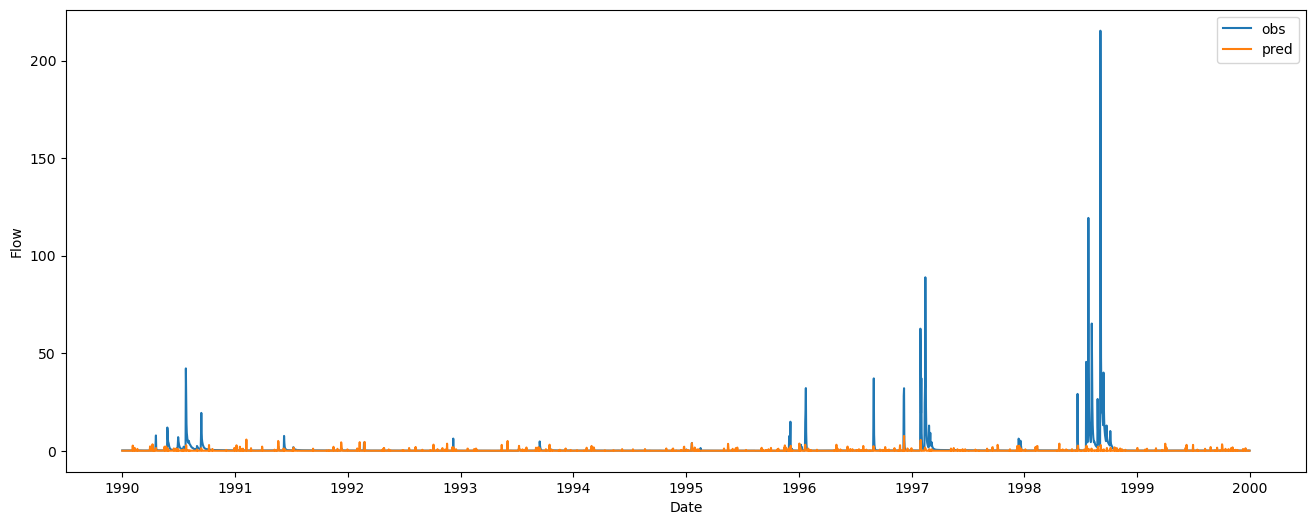

In [66]:
evaluate(model, date_calib,  et_calib, prcp_calib, flow_calib)

NSE: -1838.640
Normalized NSE: 0.001


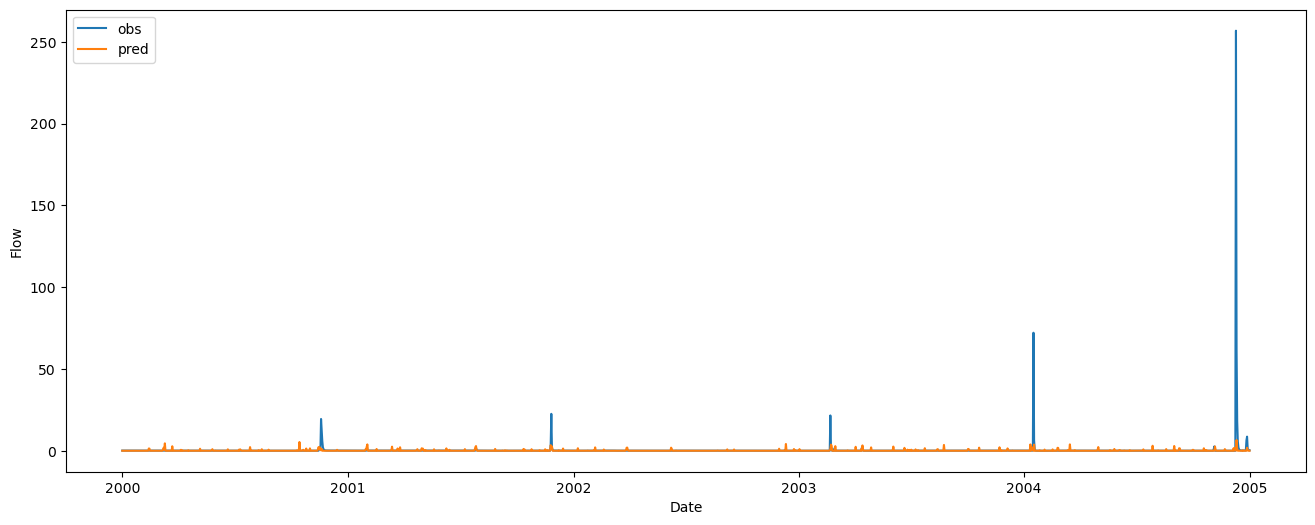

In [67]:
# Evaluate on unseen data
prcp_holdout = torch.from_numpy(holdout_data.loc[:, 'Rain'].values)
et_holdout= torch.from_numpy(holdout_data.loc[:, 'FAO56'].values)
flow_holdout = torch.from_numpy(holdout_data.loc[:, 'Value'].values)
date_holdout = holdout_data.loc[:, 'Date'].values

evaluate(model, date_holdout,  et_holdout, prcp_holdout, flow_holdout)


In [23]:
# from torch.utils.data import TensorDataset, DataLoader

# train_set = TensorDataset(
#     prcp_calib,
#     et_calib,
#     flow_calib
# )

# train_loader = DataLoader(train_set, batch_size=128)

In [68]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)


In [69]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

h1.weight tensor([[-0.2907, -0.4108,  0.0488, -0.4079],
        [-0.4175,  0.2806, -0.1541, -0.2163],
        [-0.2050, -0.2545, -0.3838, -0.0320],
        [-0.3415,  0.4591,  0.3657, -0.1352],
        [-0.1386, -0.1653,  0.0972, -0.4917],
        [-0.4098, -0.2846, -0.3463,  0.2929],
        [ 0.0038, -0.2437,  0.2639,  0.0761],
        [ 0.1572, -0.2834,  0.2408, -0.4673],
        [-0.1781, -0.1345, -0.4471,  0.1274],
        [-0.0348,  0.0844, -0.0183, -0.0570],
        [-0.0365, -0.2003,  0.2520, -0.2047],
        [ 0.0695,  0.2053, -0.0893, -0.3766],
        [ 0.3427, -0.3346,  0.3931, -0.4004],
        [ 0.0516, -0.2384,  0.2273, -0.2224],
        [-0.3466,  0.1978,  0.0529, -0.1889],
        [-0.1680,  0.4730, -0.4564, -0.3036]])
h1.bias tensor([ 0.0308, -0.0101,  0.2819,  0.4179,  0.4038,  0.0075, -0.4151,  0.1941,
        -0.2121, -0.4720,  0.3511,  0.2779,  0.1825,  0.3759, -0.2694,  0.3430])
h2.weight tensor([[ 0.1403, -0.0520,  0.0911, -0.1901, -0.0363, -0.2190, -0.0887,  0

In [70]:
for epoch in range(100):

    opt.zero_grad()

    pred_flow = model(prcp_calib, et_calib)

    loss = torch.nn.functional.mse_loss(flow_calib, pred_flow)

    loss.backward()

    opt.step()

    print(f"Epoch {epoch+1} loss: {loss.detach().numpy():.4f}")

/tmp/ipykernel_19599/2270002902.py:7: UserWarning: Using a target size (torch.Size([3652, 1])) that is different to the input size (torch.Size([3652])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(flow_calib, pred_flow)


Epoch 1 loss: 35.6071
Epoch 2 loss: 35.5629
Epoch 3 loss: 35.5629
Epoch 4 loss: 35.5629
Epoch 5 loss: 35.5629
Epoch 6 loss: 35.5629
Epoch 7 loss: 35.5629
Epoch 8 loss: 35.5629
Epoch 9 loss: 35.5629
Epoch 10 loss: 35.5629
Epoch 11 loss: 35.5629
Epoch 12 loss: 35.5621
Epoch 13 loss: 35.4727
Epoch 14 loss: 35.2787
Epoch 15 loss: 35.1155
Epoch 16 loss: 35.0741
Epoch 17 loss: 35.1495
Epoch 18 loss: 35.2129
Epoch 19 loss: 35.1939
Epoch 20 loss: 35.1271
Epoch 21 loss: 35.0636
Epoch 22 loss: 35.0304
Epoch 23 loss: 35.0277
Epoch 24 loss: 35.0409
Epoch 25 loss: 35.0540
Epoch 26 loss: 35.0570
Epoch 27 loss: 35.0473
Epoch 28 loss: 35.0284
Epoch 29 loss: 35.0060
Epoch 30 loss: 34.9863
Epoch 31 loss: 34.9740
Epoch 32 loss: 34.9703
Epoch 33 loss: 34.9731
Epoch 34 loss: 34.9774
Epoch 35 loss: 34.9776
Epoch 36 loss: 34.9714
Epoch 37 loss: 34.9602
Epoch 38 loss: 34.9479
Epoch 39 loss: 34.9382
Epoch 40 loss: 34.9332
Epoch 41 loss: 34.9319
Epoch 42 loss: 34.9313
Epoch 43 loss: 34.9270
Epoch 44 loss: 34.91

In [71]:
flow_calib, pred_flow

(tensor([0.1470, 0.1440, 0.1410,  ..., 0.0730, 0.0740, 0.0810]),
 tensor([[0.8385],
         [0.8386],
         [0.8391],
         ...,
         [0.8342],
         [0.8369],
         [0.8375]], grad_fn=<ReluBackward0>))

NSE: -3724.146
Normalized NSE: 0.000


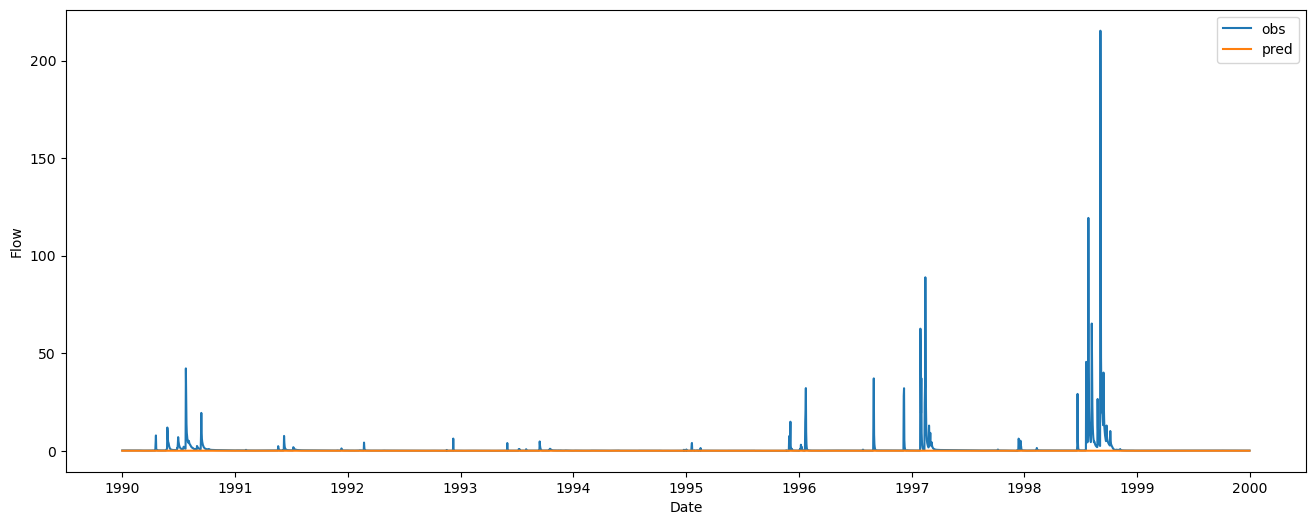

In [63]:
evaluate(model, date_calib,  et_calib, prcp_calib, flow_calib)

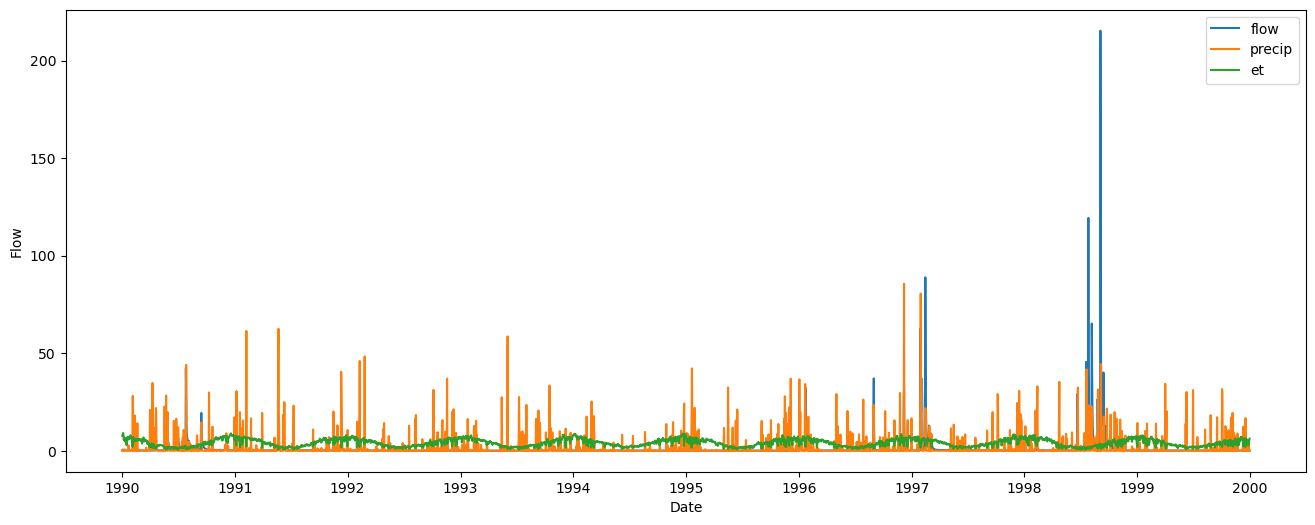

In [59]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(date_calib, flow_calib.numpy(), label='flow')
ax.plot(date_calib, prcp_calib.numpy(), label='precip')
ax.plot(date_calib, et_calib.numpy(), label='et')

ax.set_xlabel('Date')
ax.set_ylabel('Flow')

plt.legend()